# Topic Data Exploration

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Test set

In [5]:
# Check test set classifications
test = pd.read_csv('../../data/fixed-data/topic-test.csv')

test.info()
test.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10205 entries, 0 to 10204
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Headlines  10205 non-null  object
 1   Topic      10205 non-null  object
dtypes: object(2)
memory usage: 159.6+ KB


,Headlines,Topic
count,10205,10205
unique,10205,2
top,"for students, a picture is worth 1,000 words",Other
freq,1,7999


In [10]:

print(test.tail(10)[['Headlines', 'Topic']])

                                               Headlines      Topic
10195     top 10 labor day eats on a minimum-wage budget      Other
10196                     windows of opportunity, part 2      Other
10197  california church holds indoor services amid c...      Other
10198  colbert mocks trump for failing to stand up to...      Other
10199  it s a mad mad mad mad world of basque peppers...      Other
10200  markets pricing in split congress, gains under...  Economics
10201  don t let this happen to anyone else families ...      Other
10202    there are few things better than good shoe porn      Other
10203  stephen colbert suggests the perfect place for...      Other
10204  germany poised to overtake u.s. as world s no....  Economics


In [7]:
# Class distribution
print(test.groupby('Topic')['Headlines'].count() / len(test))

Topic
Economics    0.216169
Other        0.783831
Name: Headlines, dtype: float64


### Train set

In [11]:
train = pd.read_csv('../../data/fixed-data/topic-train.csv')
print(train.groupby('Topic')['Headlines'].count() / len(train))

Topic
Economics    0.220983
Other        0.779012
Name: Headlines, dtype: float64


We have a inbalanced train and test set.

In [12]:
train.info()
train.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397977 entries, 0 to 397976
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Headlines  397975 non-null  object
 1   Topic      397977 non-null  object
dtypes: object(2)
memory usage: 6.1+ MB


,Headlines,Topic
count,397975,397977
unique,397975,2
top,masterwiki is a terrible wikihow-style rip-off...,Other
freq,1,310031


Text(0.5, 1.0, 'Other')

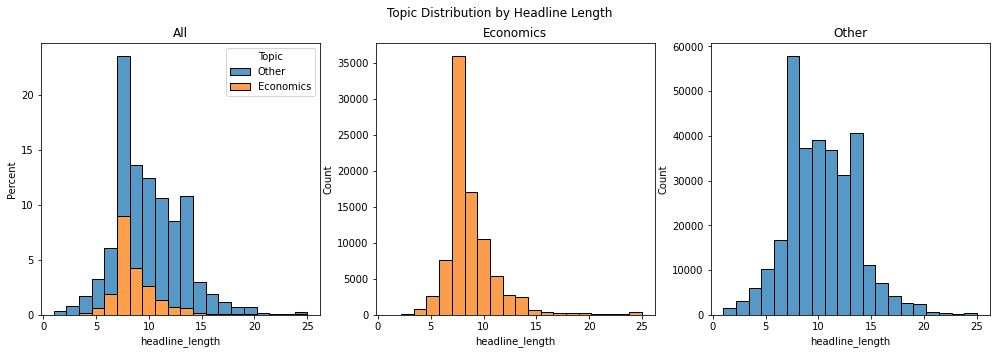

In [59]:
train['Headlines'] = train['Headlines'].astype(str)
train['headline_length'] = train['Headlines'].apply(lambda x: min(len(x.split()), 25))

fig, axes = plt.subplots(ncols=3, figsize=(17, 5))
sns.histplot(data=train, x='headline_length', hue='Topic', multiple='stack', stat='percent',
             bins=20, ax=axes[0])
economics = train[train['Topic'] == 'Economics']
other = train[train['Topic'] != 'Economics']

sns.histplot(data=economics, x='headline_length', color='#f97d11', multiple='stack',
             bins=20, ax=axes[1])
sns.histplot(data=other, x='headline_length', multiple='stack',
             bins=20, ax=axes[2])

fig.suptitle('Topic Distribution by Headline Length')
axes[0].set_title('All')
axes[1].set_title('Economics') 
axes[2].set_title('Other')

The two topics have a very different topic length distributions, which might impact the model negatively.

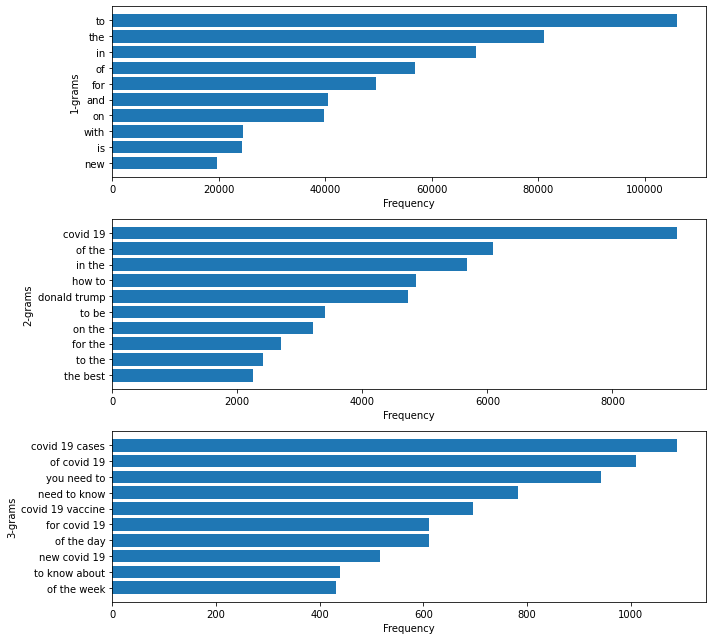

In [60]:
from sklearn.feature_extraction.text import CountVectorizer


def get_ngrams(corpus, ngrams=1, relative=False):
    """Get all n-grams from a corpus of text.
    
    Args:
        corpus: A list of strings representing the text documents.
        ngrams: The size of the n-grams to be extracted (default: 1).
        relative: If True, returns relative frequencies (default: False).
    
    Returns:
        A tuple containing two lists: n-gram words and their corresponding frequencies.
    """
    vec = CountVectorizer(ngram_range=(ngrams, ngrams)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    words, frequencies = zip(*words_freq)
    if relative:
        frequencies = frequencies / np.sum(frequencies)
    return words, frequencies


def plot_top_ngrams(ax, corpus, ngrams=1, top_k=10):
    """Plot the top k n-grams from a corpus of text."""
    words, frequencies = get_ngrams(corpus, ngrams=ngrams)
    words, frequencies = words[:top_k], frequencies[:top_k]
    ax.barh(words, frequencies)
    ax.invert_yaxis()
    ax.set_xlabel('Frequency')
    ax.set_ylabel(f'{ngrams}-grams')


fig, axes = plt.subplots(3, 1, figsize=(10, 9))
plot_top_ngrams(axes[0], train['Headlines'], ngrams=1)
plot_top_ngrams(axes[1], train['Headlines'], ngrams=2)
plot_top_ngrams(axes[2], train['Headlines'], ngrams=3)
plt.tight_layout()
plt.show()

The high relative frequency of *covid-19* in the dataset suggests that it may be dominated by recent articles, potentially leading to overfitting of the model based on the news coverage during that period

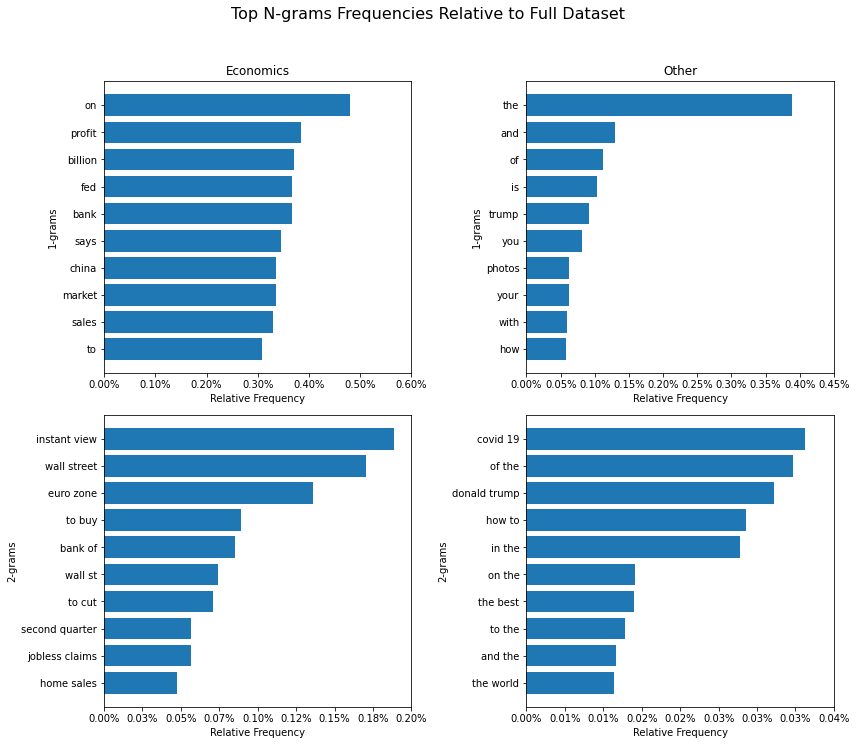

In [62]:
def plot_top_ngrams_relative(ax, corpus, total_counts, ngrams=1, top_k=10):
    """ Plot the top k n-grams relative to the total dataset for a given corpus.
    
    I.e. if 'bull' is 0.2% of the total dataset and 0.6% of the corpus, then the relative
    frequency of 'bull' is 0.6 - 0.2 = 0.4 %.
    
    Args:
        ax: A matplotlib axes object for plotting.
        corpus: A list of strings representing the text documents.
        total_counts: A dictionary containing the total counts of n-grams for all topics.
        ngrams: The size of the n-grams to be extracted (default: 1).
        top_k: The number of top n-grams to display (default: 10).
    """
    word_freq = get_ngrams(corpus, ngrams=ngrams, relative=True)
    relative_word_freq = [(w, f - total_counts[w]) for w, f in zip(*word_freq)]
    words_freq = sorted(relative_word_freq, key=lambda x: x[1], reverse=True)[:top_k]
    words, relative_frequencies = zip(*words_freq)

    ax.barh(words, relative_frequencies)
    ax.invert_yaxis()
    ax.set_xlabel('Relative Frequency')
    ax.set_ylabel(f'{ngrams}-grams')
    # Set x-axis to percentage
    xticks = ax.get_xticks()
    ax.set_xticks(xticks)
    ax.set_xticklabels(['{:,.2%}'.format(x) for x in xticks])


total_1ngrams = get_ngrams(train['Headlines'], ngrams=1, relative=True)
total_1ngrams = dict(zip(*total_1ngrams))
total_2ngrams = get_ngrams(train['Headlines'], ngrams=2, relative=True)
total_2ngrams = dict(zip(*total_2ngrams))

topics = ['Economics', 'Other']
num_topics = len(topics)
fig, axes = plt.subplots(2, num_topics, figsize=(6 * num_topics, 10))

for col, topic in enumerate(topics):
    headlines = train[train['Topic'] == topic]['Headlines']
    axes[0, col].set_title(topic)
    plot_top_ngrams_relative(axes[0, col], headlines, total_counts=total_1ngrams, ngrams=1)
    plot_top_ngrams_relative(axes[1, col], headlines, total_counts=total_2ngrams, ngrams=2)

fig.suptitle('Top N-grams Frequencies Relative to Full Dataset', fontsize=16, y=1.03)
plt.tight_layout()
plt.show()

### Some conclusions

- The dataset is imbalanced.
    - Either optimize a loss function that takes this into account
    - Or repeat 'Economics' headlines until the dataset is balanced.
- The amount of `covid-19` n-grams should be looked into. It means that the COVID-era headlines dominates dataset, which might not represent normal news coverage. 
- The two topics have a very different sentence length distributions.

Overall, the dataset quality should be improved before starting training models.